In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns

%matplotlib inline

## Load annotation table

In [2]:
MAXSIZE = 100

# Read table
my_cols = [i for i in range(MAXSIZE)]
df = pd.read_csv("data/CCF/template/Mouse.csv", names=my_cols, engine='python', 
                 skiprows=[0], 
                 index_col=[1], 
                 skipinitialspace=True)
df = df.drop([0,3,4,5,6,7,8], axis=1)
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i,j] is None:
            df.iloc[i,j] = np.nan
df.columns = ["Abbrevation"]+["Level_"+str(i) for i in range(1, df.shape[1])]
df_isnull = df.isnull()

# Get levels of each row 
level = []
description = []
MAXLEVEL = 0
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if not df_isnull.iloc[i,j]:
            level.append(j)
            description.append(df.iloc[i,j])
            break
MAXLEVEL = np.max(level)
level = pd.DataFrame({'level':level, 'Abbrevation':df.Abbrevation.tolist() ,'Description':description},
                      index=df.index)

# Drop redundant columns
df = df.iloc[:, :(MAXLEVEL+2)]  # The last column will contain only NaN
df_isnull = df.isnull()

In [5]:
df_fill = df.copy()
for i in range(1, df.shape[1]):
    cur_region = None
    for j in range(df.shape[0]):
        if not df_isnull.iloc[j,i]:
            cur_region = df.iloc[j,i]
            cur_level = level.iloc[j,0]
        elif (not cur_region is None) & (cur_level<level.iloc[j,0]):
                df_fill.iloc[j,i] = cur_region

# Check valid
df_fill_isnull = df_fill.isnull()
for i in range(len(df)):
    for j in range(1, df.shape[1]):
        if df_fill_isnull.iloc[i,j]:
            if(level.iloc[i,0] != (j-1)):
                print(i)
            break                

def cut_by_level(df_fill, level=None):
    '''
    Return the deepest levels possible of a taxonomy tree
    '''
    if level is None:
        level = df_fill.shape[1]-1
    # 1. Remove terms deeper than the level threshold
    df_fill_isnull = df_fill.isnull()
    drop_list = []
    for i in range(df_fill.shape[0]):
        if not df_fill_isnull.iloc[i, level+1]:
            drop_list.append(df_fill.index[i])
    df_fill = df_fill.drop(drop_list)
    df_fill_isnull = df_fill.isnull()
    # 2. Remove internal terms
    drop_list = []
    for i in range(df_fill.shape[0]):
        for j in range(1, level+1):
            if df_fill_isnull.iloc[i,j]: 
                check_column = j-1
                check_name = df_fill.iloc[i, check_column]
                if df_fill.iloc[:, check_column].value_counts()[check_name] > 1:  # the current term is the parent node of some other terms
                    drop_list.append(df_fill.index[i])
                break
    df_fill = df_fill.drop(drop_list)
    return df_fill

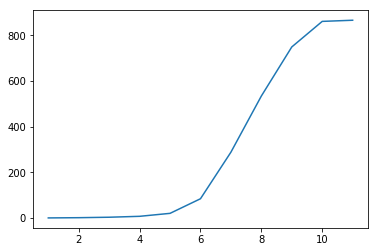

In [6]:
region_ct = []
for i in range(1, MAXLEVEL+1):
    tp = cut_by_level(df_fill, i)
    tp = tp[tp["Level_2"]=="Basic cell groups and regions"]
    tp = level.loc[tp.index]
    region_ct.append(len(tp))
    
plt.plot(np.arange(1, MAXLEVEL+1), region_ct)

In [7]:
brain_regions = cut_by_level(df_fill, 8)
brain_regions = brain_regions[brain_regions["Level_2"]=="Basic cell groups and regions"]
brain_levels = level.loc[brain_regions.index]

print(brain_levels.shape)
brain_levels.head()

(534, 3)


,level,Abbrevation,Description
1,,,
68,8,FRP1,"Frontal pole, layer 1"
667,8,FRP2/3,"Frontal pole, layer 2/3"
526157192,8,FRP5,"Frontal pole, layer 5"
526157196,8,FRP6a,"Frontal pole, layer 6a"
526322264,8,FRP6b,"Frontal pole, layer 6b"


## Load neuron distribution

In [143]:
dendrite_location = pd.DataFrame(columns=brain_levels.index)
axon_location = pd.DataFrame(columns=brain_levels.index)
hemi_location = pd.DataFrame(columns=['hemisphere'])
ncol = brain_levels.shape[0]

data_dir = "./data/CCF/mapped/location/"
standard_columns = ['Unnamed: 0', '(basal) dendrite', 'axon', 'dataset', 'hemisphere_id', 'structure_id']

for input_table in os.listdir(data_dir):
    if input_table.endswith(".csv"):
        input_table = os.path.join(data_dir, input_table)
    else:
        continue
    df = pd.read_csv(input_table)
    
    # Check column names 
    check_columns = True
    if df.shape[1] != len(standard_columns):
        print(input_table)
        continue
    for i,col in enumerate(df.columns.tolist()):
        if col != standard_columns[i]:
            print(input_table)
            check_columns = False
            break
    if not check_columns:
        continue
        
    # Load table  
    df = pd.read_csv(input_table, index_col=[5])
    df = df.drop([df.columns[0]], axis=1)
    df = df.fillna(0)
    cell_id = '_'.join(df.dataset.iloc[0].split('_')[:2])
    hemi_id = df.hemisphere_id.iloc[0]
    df.dataset = cell_id

    # Remove unwanted rows
    lab = []
    for i in range(len(df)):
        if not df.index[i] in brain_levels.index.tolist():
            lab.append(df.index[i])
    df = df.drop(lab)

    # Dendrite
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["(basal) dendrite"].tolist()
    dendrite_location = pd.concat([dendrite_location, tp])
    # Axon
    tp = pd.DataFrame(np.zeros((1, ncol)), columns=brain_levels.index, index=[cell_id])
    tp[df.index] = df["axon"].tolist()
    axon_location = pd.concat([axon_location, tp])
    # hemisphere
    tp = pd.DataFrame([hemi_id], columns=['hemisphere'], index=[cell_id])
    hemi_location = pd.concat([hemi_location, tp])

dendrite_location.columns = brain_levels.loc[dendrite_location.columns, 'Description']
axon_location.columns = brain_levels.loc[axon_location.columns, 'Description']

./data/CCF/mapped/location/17302_070_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_091_SYY_WW_ZSJ_08032018.ano.eswc.csv
./data/CCF/mapped/location/17302_069_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_022_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_058_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_073_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_061_LjL_09072018.ano.eswc.csv
./data/CCF/mapped/location/17302_051_ChenXP_SYY_07312018.ano.eswc.csv
./data/CCF/mapped/location/17302_067_LiuAn_LijLiu_05152018.ano.swc.csv
./data/CCF/mapped/location/17302_045_LjLiu_05132018.ano.eswc.csv
./data/CCF/mapped/location/17302_085_HGD_LijLiu_07282018.ano.eswc.csv
./data/CCF/mapped/location/17302_031_HGD_LijLiu_07062018.ano.eswc.csv
./data/CCF/mapped/location/17302_068_LiuAn_LijLiu_05152018.ano.swc.ano.swc.csv
./data/CCF/mapped/location/17302_072_YJ_LjL_09032018.ano.eswc.csv
./data/CCF/mapped/location/17302_071_YJ_Lj

In [145]:
pickle.dump([dendrite_location, axon_location, hemi_location, brain_levels, brain_regions],
           open("data/CCF/mapped/location/17302_location.pickle", 'wb'))

location_sum = pd.DataFrame(np.sum(axon_location + dendrite_location, axis=0)).sort_values(0, ascending=False)
lab = location_sum[location_sum[0]>0].index

writer = pd.ExcelWriter('Table/17302_location.xlsx')
dendrite_location[lab].to_excel(writer,'Dendrite')
axon_location[lab].to_excel(writer,'Axon')
hemi_location.to_excel(writer,'Hemisphere')
brain_levels.to_excel(writer, 'Brain_regions')
writer.save()

## Examine brain region assignment

Regions used:	 16


,0
Description,
Caudoputamen,110576.984332
Primary visual area,21532.186581
Primary somatosensory area,20441.456322
"Substantia nigra, reticular part",15852.497528
Primary auditory area,7705.090635
"Gustatory areas, layer 6a",6892.678766
Supplemental somatosensory area,6759.121775
Claustrum,6502.433237
"Orbital area, ventrolateral part",6242.298202


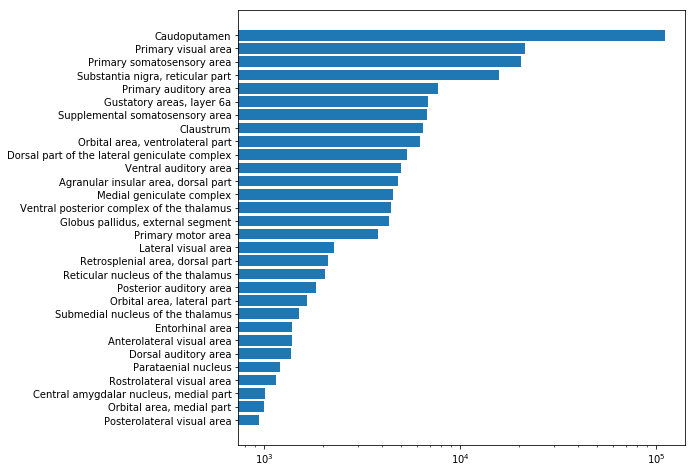

In [148]:
features = pd.read_excel("Table/Global_features.xlsx")
location_all = axon_location + dendrite_location
# location = dendrite_location
use_cells = sorted(list(set(features.index).intersection(set(location.index))))

features = features.loc[use_cells]
location = location_all.loc[use_cells]
# location.columns = brain_levels.loc[location.columns, "Description"]


# Cell types
celltypes = pd.DataFrame(features['Type'])
u_celltypes = list(set(celltypes['Type']))

assert len(u_celltypes)<10
celltypes_pal = ['C'+str(i) for i in range(len(u_celltypes))]
celltypes_lut = dict(zip(sorted(u_celltypes), celltypes_pal))
celltypes_col = []
for tp in celltypes['Type'].tolist():
    celltypes_col.append(celltypes_lut[tp])


location_sum = pd.DataFrame(np.sum(location, axis=0)).sort_values(0, ascending=False)

plt.figure(figsize=(8,8))
n_disp = 30
plt.barh(np.linspace(n_disp,1,n_disp), location_sum.iloc[:n_disp, 0], tick_label=location_sum.index[:n_disp])
plt.xscale('log')

lab = [i for i in range(location.shape[1]) if location.iloc[:,i].sum()>np.percentile(location_sum[0], 97)]

print("Regions used:\t", len(lab))
location = location.iloc[:, lab]
location_sum.iloc[0:n_disp, :]

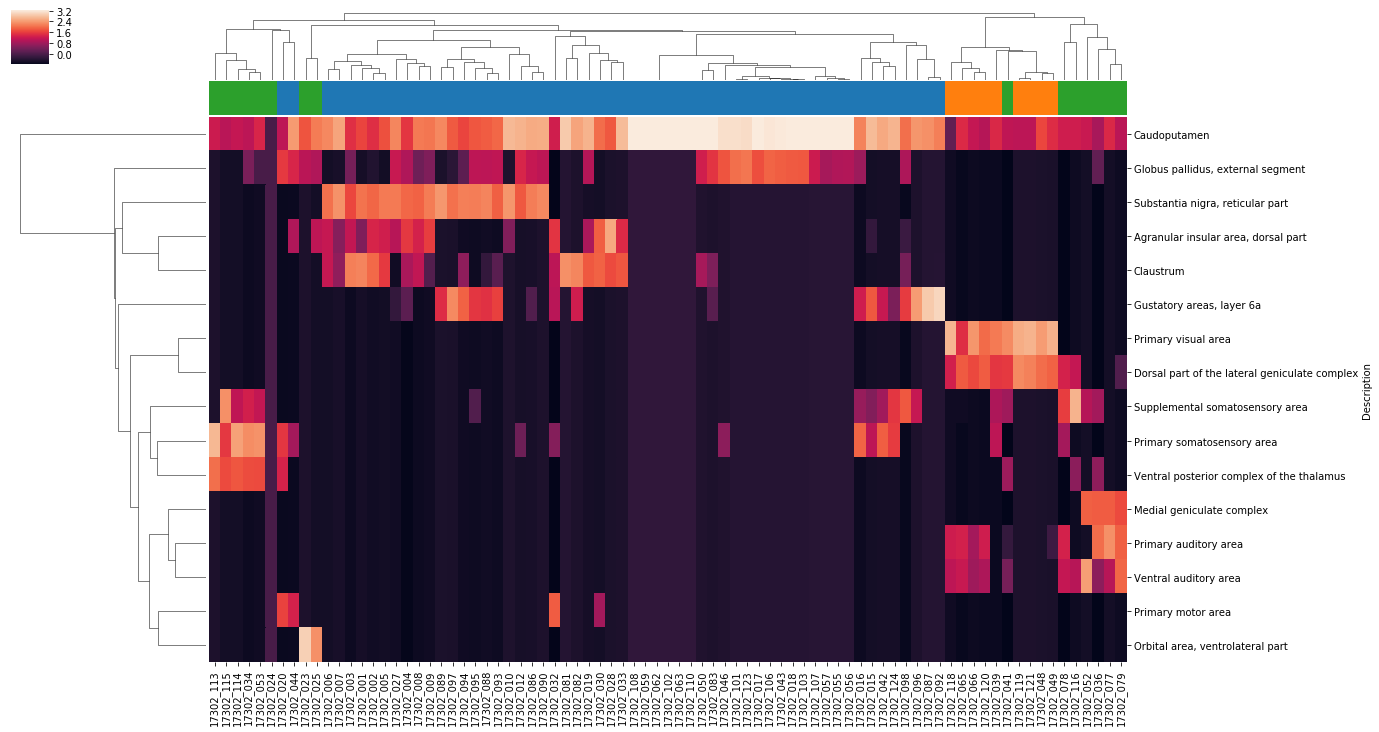

In [149]:
df = pd.DataFrame(scale(np.log10(location+1), axis=1), columns=location.columns, index=location.index)
g = sns.clustermap(df.transpose(), linewidths=0.0, linecolor='white',
                   col_colors=celltypes_col,
                   vmax=np.percentile(df, 99),
                   vmin=np.percentile(df, 1),
                   annot=False, figsize=(20,12))
g.savefig("Figure/Heatmap_Location_AllNeurons.pdf")

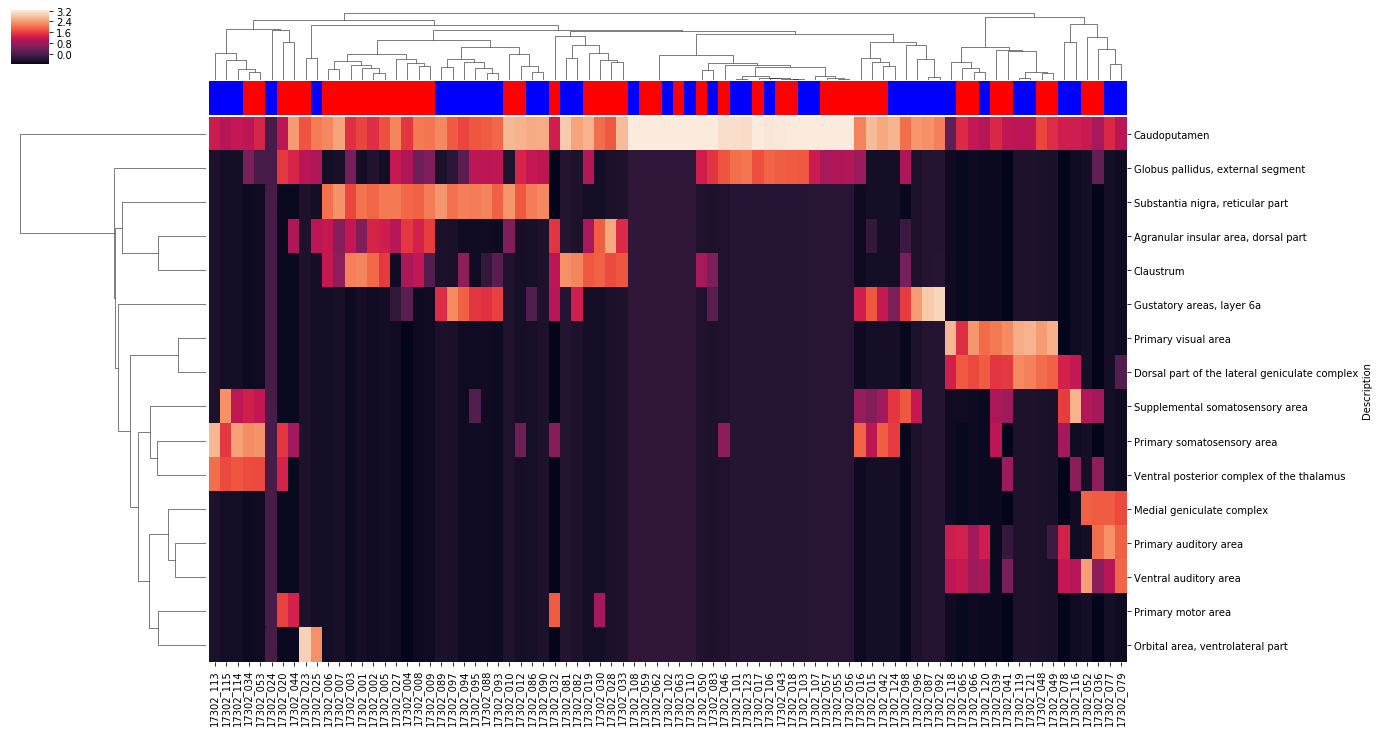

In [152]:
hemi_lut = {1:'r', 2:'b'}
# hemi_col = ["C"+str(i) for i in hemi_location.loc[df.index, 'hemisphere'].tolist()]
hemi_col = [hemi_lut[i] for i in hemi_location.loc[df.index, 'hemisphere'].tolist()]


g = sns.clustermap(df.transpose(), linewidths=0.0, linecolor='white',
                   col_colors=hemi_col,
                   vmax=np.percentile(df, 99),
                   vmin=np.percentile(df, 1),
                   annot=False, figsize=(20,12))
g.savefig("Figure/Heatmap_Location_AllNeurons.by_hemisphere.pdf")